# Zaawansowane przetwarzanie obrazu

## Ćwiczenie laboratoryjne 5 – sieci neuronowe w rozwiązywaniu zadań segmentacji




## Wstęp

Nasze praktyczne doświadczenia z sieciami neuronowymi zaczęliśmy od klasyfikacji – która mimo bycia najbardziej "podstawowym" problemem (a może też właśnie dlatego), nadal jest w ścisłej czołówce (pod względem  częstotliwości występowania) zadań, które rozwiązuje się w praktyce. Natomiast nie ma co ukrywać – niczego lepszego do klasyfikacji po pokemonach już nie znajdziemy (może ewentualnie pomijając święty graal informatyki, czyli klasyfikację nosaczy, ale trzeba by samemu zebrać ich zdjęcia) – ruszajmy więc w wir dalszej przygody, i przejdźmy do kolejnych klas problemów przetwarzania obrazu, które możemy rozwiązać.

Dzisiejszym tematem będzie segmentacja – czyli wyodrębnianie z obrazów pewnych ich fragmentów, zawierających konkretne obiekty czy obszary zainteresowania, poprzez przypisanie im odpowiedniej klasy.



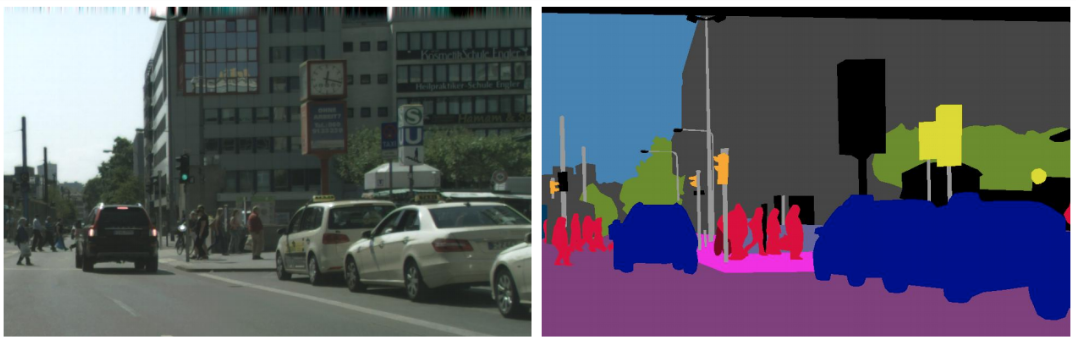

W zasadzie zadanie to można potraktować jako rozszerzoną wersję klasyfikacji, w której jedną z góry określonych C klas musimy przypisać nie do całości obrazu, a każdemu indywidualnemu pikselowi który się w nim znajduje.

Również tutaj trening przebiega w sposób nadzorowany – natomiast z uwagi na to, że musimy nadać klasy wszystkim pikselom, to naszą zmienną zależną (<b><i>ground_truth</i></b>) nie będą tak jak wcześniej pojedyncze liczbowe identyfikatory klas, a raczej tensor, o rozmiarach (C x H x W), gdzie H i W odpowiadają wysokości/szerokości wejściowego obrazu a C to liczba klas do których piksel może być przypisany (przynależność zazwyczaj zakodowana jest w postaci one hot encoding).

Przykładowo poniżej mamy zwizualizowaną wejście i wyjście (pojedyncza próbka), dla sieci której zadaniem jest segmentacja mózgu, ze skanów MRI głowy. Dane wejściowe mają rozmiar 200 (wysokość) x 200 (szerokość) x 1 (liczba kanałów – skala szarości) a dane wyjściowe rozmiar 200 (wysokość – identyczna jak dla wejścia) x 200 (szerokość – identyczna jak dla wejścia) x 1 (liczba klas których prawdpodobieństwo przewidujemy – w tym przypadku klasa jest jedna – tkanka mózgowa, mamy tu do czynienia z segmentacją binarną).

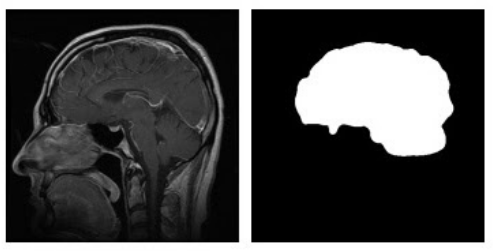

Mimo, że tak jak padło wcześniej, segmentację możemy traktować jako "rozszerzenie" klasyfikacji, to jest ona w ogólności zadaniem trudniejszym, do którego rozwiązywania stosuje się trochę inne niż dotychczasowo przez nas poznane architektury. Innym jej aspektem jest również to, że zazwyczaj mamy do czynienia ze zdecydowanie mniejszą ilością dostępnych danych treningowych – ich oznaczanie jest zdecydowanie bardziej pracochłonne niż oznaczenie próbek do klasyfikacji.
Jednak jak już widzieliśmy w przykładach, problemy te nie oznaczają, że rozwiązanie takich zadań jest niemożliwe (chociaż często trudne), i w praktyce udało się z sukcesem zaaplikować modele segmentacyjne w dziedzinach takich jak:


* medycyna (systemy wykrywające automatycznie z obrazów określone struktury czy rodzaje tkanek – np. nowotworowych),
* pojazdy autonomiczne (jedną z podstaw systemu odpowiadającego za poruszanie się samochodów Tesla są kamery, z których obraz jest segmentowany tak, aby umożliwić zrozumienie systemowi otoczenia i podjęcie odpowiednich decyzji),
* obrazowanie satelitarne (przykładowo wykrywanie na zdjęciach potencjalnych lokalizacji cennych złóż),
* i wiele innych...

## Instalacja zależności

In [1]:
!pip install lightning neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=f61c891018d214be8b5984b66430030bf7c9972ae3041ecac9d58592b

## Przygotowanie danych

Reguła mówiąca, że dane są zdecydowanie przydatne przy machine learningu nadal obowiązuje, tak jak na początku semestru – zacznijmy więc prace od ich przygotowania.


Na tych zajęciach zajmiemy się przygotowaniem modelu, pozwalającego na wysegmentowywanie psów ze zdjęć (można go potem np. podpiąć do monitoringu i wreszcie ustalić który z nich pod nieobecność właściciela zostawia zaślinia poduszki bez konieczności oglądania całego nagrania). Dane oryginalnie pochodzą ze zbioru [Oxford-IIIT Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), natomiast zostały trochę uproszone na potrzeby laboratoriów – przetworzona postać znajduje się pod następującym adresem:
https://drive.google.com/file/d/1-LVOBKBessiq21RSWN4sSwulQ5eA4XD4/view?usp=sharing

<b>TODO4YOU</b>

Pobierz z podanego adresu dataset na swój własny Google Drive, "podepnij" go do Colaba, a następnie rozpakuj go do systemu plików bieżącej sesji, tak by znajdował sie na dysku maszyny na której działa nasz notebook.

<b>Ważne:</b> Ostatnia część jest dość istotna – gdy korzystajamy z danych zamountowanych do bieżącej sesji, ale nadal znajdujących się na Google Drivie ich wczytywanie będzie wolniejsze – chmurowy system plików jest zupełnie inny niż w "normalnych" maszynach (mimo, że z poziomu systemu operacyjnego będzie widoczny tak samo) i mniej nadaje się częstego wczytywania pojednyczych plików – co będziemy robili później, gdyż nie zawsze całość danych da się wczytać do pamięci. W praktycznych scenariuszach prędkość wczytywania danych z dysku jest zazwyczaj istotna – często z tego względu na czas treningu przenosi się je na dyski NVMe/SSD.

<b>Wskazówka:</b> W razie ewentualnej potrzeby, jak podłączyć dane z Google Drive do Colaba opisane jest w instrukcji do pierwszych zajęć.

In [2]:
!pip install -U gdown

In [3]:
!gdown "https://drive.google.com/uc?id=1-LVOBKBessiq21RSWN4sSwulQ5eA4XD4" -O /content/dataset.zip

import zipfile
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Downloading...
From (original): https://drive.google.com/uc?id=1-LVOBKBessiq21RSWN4sSwulQ5eA4XD4
From (redirected): https://drive.google.com/uc?id=1-LVOBKBessiq21RSWN4sSwulQ5eA4XD4&confirm=t&uuid=29970ae1-d4c3-46aa-a111-4329dfe860ee
To: /content/dataset.zip
100% 1.61G/1.61G [01:18<00:00, 20.5MB/s]


In [4]:
!unzip oxford_pets_dogs_only_binarized_split.zip

unzip:  cannot find or open oxford_pets_dogs_only_binarized_split.zip, oxford_pets_dogs_only_binarized_split.zip.zip or oxford_pets_dogs_only_binarized_split.zip.ZIP.


Skoro mamy już dostęp do danych, zajmijmy się ich ich wczytywaniem – z uwględnieniem scenariusza, że nie mieszczą się one wszystkie do pamięci (chociaż w przypadku tego datasetu raczej powinny). Z tym problemem można sobie poradzić bardzo prosto – przygotowując (i później podając w metodzie <b><i>fit</i></b>) PyTorchowy Dataset, który będzie ładował z dysku próbki danych. Przy okazji można w nim zaimplementować augmentację danych.

In [5]:
import torch
import numpy as np
import albumentations as A

from torch.utils.data import Dataset

from pathlib import Path
from PIL import Image


class DogsDataset(Dataset):
    def __init__(self, images_paths: list[Path], transforms: A.Compose):
        self._images_paths = images_paths
        self._transforms = transforms

    def __len__(self):
        return len(self._images_paths)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        image_path = self._images_paths[index]
        image = np.asarray(Image.open(image_path).convert('RGB'))

        mask_path = image_path.parent.parent / 'labels' / image_path.name
        mask = np.asarray(Image.open(mask_path))

        transformed = self._transforms(image=image, mask=mask)

        return transformed['image'], transformed['mask'].type(torch.long)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
import cv2
import os
import shutil
from urllib.request import urlopen
from pathlib import Path

import lightning.pytorch as pl
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
import albumentations.pytorch.transforms


class DogsDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.augmentations = A.Compose([
            A.Resize(width=256, height=256),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.5),
            # A.Downscale(scale_range=(0.5, 0.75), interpolation_pair={'downscale': cv2.INTER_NEAREST, 'upscale': cv2.INTER_LINEAR},p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.pytorch.transforms.ToTensorV2(),
        ])
        self.transforms = A.Compose([
            A.Resize(width=256, height=256),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.pytorch.transforms.ToTensorV2(),
        ])

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def setup(self, stage):
        dataset_path = Path('oxford_pets_dogs_only_binarized_split')
        train_paths = sorted((dataset_path / 'train' / 'images').glob('*.png'))
        test_paths = sorted((dataset_path / 'test' / 'images').glob('*.png'))

        train_paths, val_paths = train_test_split(train_paths, test_size=0.2,
                                                  random_state=42)

        self.train_dataset = DogsDataset(train_paths, self.augmentations)
        self.val_dataset = DogsDataset(val_paths, self.transforms)
        self.test_dataset = DogsDataset(test_paths, self.transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=32, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=32)

<b>TODO4YOU</b>

Po implementacji klasy dziedziczącej po `Dataset`, posłuż się nią aby wczytać przykładową próbkę danych, i wyświetl ją (mogą być na potrzebę tego ostatniego potrzebne pewne konwersje typów).

In [7]:
data_module = DogsDataModule()
data_module.setup('')

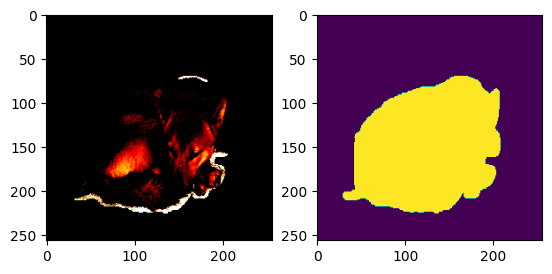

In [8]:
import matplotlib.pyplot as plt

image, mask = data_module.train_dataset[16]
image = image.permute(1, 2, 0)
image[mask == 0] = torch.tensor([0.0, 0.0, 0.0])
fig, axes = plt.subplots(ncols=2, nrows=1)
axes[0].imshow(image)
axes[1].imshow(mask)
plt.show()


**Pożądana** para danych:

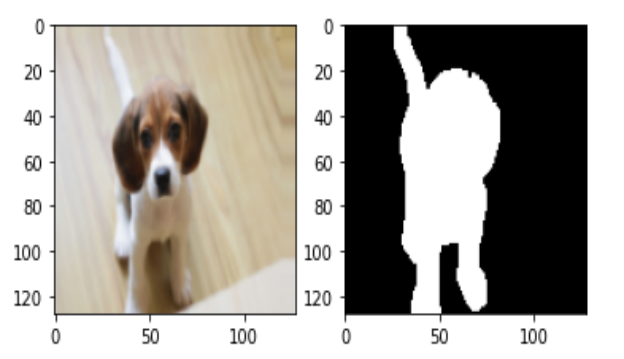

Mniej pożądana para danych:

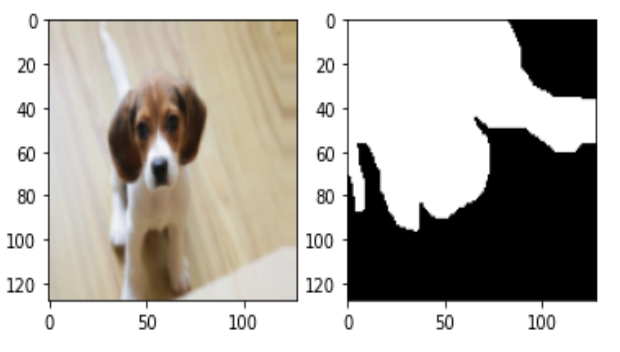

<b>TODO4YOU</b>

Przygotuj prostą funkcję, która pozwoli na wyświetlenie zawartości oryginalnego obrazu wskazywanej przez odpowiadającą mu maskę. Sprawdź, jak dokładnie maski odpowiadają "rzeczywistym" (TODO: czy na płaszczyźnie zespolonej istnieją psy urojone? Sprawdzić po skończeniu instrukcji) psom w obrazie.

<b>SPOILERS AHEAD – przeczytać dopiero po wykonaniu poprzedniego zdania</b>

<b>Uwaga:</b> jak można zobaczyć po wyświetleniu paru próbek, maski są trochę "nadmiarowe" – w ogólności jak największa dokładność oznaczeń w danych jest zdecydowanie pożądana – ale w naszym przypadku delikatnie przymkniemy na to oko.

## Sieci segmentacyjne

### Architektura enkoder-dekoder

Podstawą najpopularniejszych architektur wykorzystywanych do segmentacji jest tak struktura sieci zwana enkoder-dekoder. Składają się one z dwóch części: enkodera, który w zasadzie już znamy – zbudowany jest on analogicznie do znanych nam już części klasyfikatorów, odpowiadających za ekstrakcję cech z obrazów – tutaj służy on w tym samym celu. Dekoder z kolei, korzysta z cech/reprezentacji wyekstrachowanej przez enkoder i własnych wyuczonych warstw/wag, żeby wyprodukować finalny output modelu – maskę segmentacji.

Oczywiście wszyscy byli na wykładzie, i już to (a także zdecydowanie więcej) wiedzą – dlatego tutaj poprzestaniemy (ale jakby ktoś jednak czegoś nie wiedział, i potrzebował drobnej powtórki z teorii – to znajduje się ona w 5 prezentacji z materiałów wykładowych).


Zdjęcie dorosłego osobnika sieci enkoder-dekoder zrobione przez National Geographic:

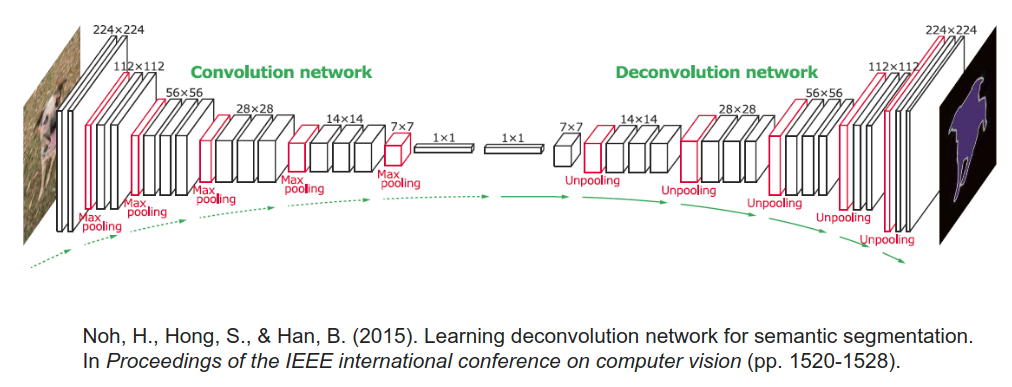

<b>TODO4YOU</b>

Generator danych jest już przygotowany – zajmijmy się samą strukturą sieci. Docelowo sprawdzimy, czy wspomniana struktura enkoder-dekoder poradzi sobie z naszymi psiakami.

Przygotuj architekturę enkoder-dekoder, na podstawie podsumowania modelu z poniższego zdjęcia (jeśli chcesz, możesz ją "zcustomizować" zgodnie ze swoją intuicją). Jakie funkcje aktywacji powinny być stosowane w kolejnych warstwach?


```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           9,248
              ReLU-4         [-1, 32, 128, 128]               0
         MaxPool2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
              ReLU-9           [-1, 64, 64, 64]               0
        MaxPool2d-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
             ReLU-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]         147,584
             ReLU-14          [-1, 128, 32, 32]               0
        MaxPool2d-15          [-1, 128, 16, 16]               0
           Conv2d-16          [-1, 256, 16, 16]         295,168
             ReLU-17          [-1, 256, 16, 16]               0
           Conv2d-18          [-1, 256, 16, 16]         590,080
             ReLU-19          [-1, 256, 16, 16]               0
        MaxPool2d-20            [-1, 256, 8, 8]               0
           Conv2d-21            [-1, 256, 8, 8]         590,080
             ReLU-22            [-1, 256, 8, 8]               0
           Conv2d-23            [-1, 256, 8, 8]         590,080
             ReLU-24            [-1, 256, 8, 8]               0
UpsamplingNearest2d-25          [-1, 256, 16, 16]             0
           Conv2d-26          [-1, 128, 16, 16]         295,040
             ReLU-27          [-1, 128, 16, 16]               0
           Conv2d-28          [-1, 128, 16, 16]         147,584
             ReLU-29          [-1, 128, 16, 16]               0
UpsamplingNearest2d-30          [-1, 128, 32, 32]             0
           Conv2d-31           [-1, 64, 32, 32]          73,792
             ReLU-32           [-1, 64, 32, 32]               0
           Conv2d-33           [-1, 64, 32, 32]          36,928
             ReLU-34           [-1, 64, 32, 32]               0
UpsamplingNearest2d-35           [-1, 64, 64, 64]             0
           Conv2d-36           [-1, 32, 64, 64]          18,464
             ReLU-37           [-1, 32, 64, 64]               0
           Conv2d-38           [-1, 32, 64, 64]           9,248
             ReLU-39           [-1, 32, 64, 64]               0
UpsamplingNearest2d-40         [-1, 32, 128, 128]             0
           Conv2d-41         [-1, 32, 128, 128]           9,248
             ReLU-42         [-1, 32, 128, 128]               0
           Conv2d-43          [-1, 1, 128, 128]             289
================================================================
Total params: 2,943,009
Trainable params: 2,943,009
Non-trainable params: 0
----------------------------------------------------------------
```

In [9]:
from torch import nn

class SegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # Conv2d-1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1) # Conv2d-3
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # MaxPool2d-5

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Conv2d-6
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  # Conv2d-8
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # MaxPool2d-10

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Conv2d-11
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)  # Conv2d-13
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)  # MaxPool2d-15

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # Conv2d-16
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # Conv2d-18
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)  # MaxPool2d-20

        self.conv9 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # Conv2d-21
        self.conv10 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # Conv2d-23

        # Decoder
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')  # UpsamplingNearest2d-25
        self.conv11 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)  # Conv2d-26
        self.conv12 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)  # Conv2d-28

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')  # UpsamplingNearest2d-30
        self.conv13 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)  # Conv2d-31
        self.conv14 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  # Conv2d-33

        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')  # UpsamplingNearest2d-35
        self.conv15 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)  # Conv2d-36
        self.conv16 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # Conv2d-38

        self.upsample4 = nn.Upsample(scale_factor=2, mode='nearest')  # UpsamplingNearest2d-40
        self.conv17 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # Conv2d-41
        self.conv18 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=3, padding=1)  # Conv2d-43

    def forward(self, x):
        # Encoder
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool1(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.maxpool2(x)

        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.maxpool3(x)

        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.maxpool4(x)

        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))

        # Decoder
        x = self.upsample1(x)
        x = self.relu(self.conv11(x))
        x = self.relu(self.conv12(x))

        x = self.upsample2(x)
        x = self.relu(self.conv13(x))
        x = self.relu(self.conv14(x))

        x = self.upsample3(x)
        x = self.relu(self.conv15(x))
        x = self.relu(self.conv16(x))

        x = self.upsample4(x)
        x = self.relu(self.conv17(x))
        x = self.conv18(x)

        return x


In [10]:
model = SegmentationModel()
model(torch.rand(1, 3, 128, 128)).shape

torch.Size([1, 2, 128, 128])

<b>TODO4YOU</b>

Mamy już przygotowany zarówno model, jak i źródło danych. Chociaż właściwie nie do końca – żeby postąpić "zgodnie ze sztuką", przydałby się nam jeszcze zbiór walidacyjny – w tym celu możemy wykorzystać kod generatora który już mamy – ale najpierw trzeba wydzielić na dysku osobne katalogi z danymi walidacyjnymi.

Wydziel ze zbioru treningowego odpowiednią strukturę katalogów, zawierającą 15% zdjęć/masek oryginalnego zbioru. Następnie, wykorzystując już przygotowany kod, utwórz generator danych walidacyjnych (zastanów się – czy zbiór walidacyjny może/powinien być poddawany augmentacji?).

<b>Wskazówka:</b> do manipulacji systemem plików z poziomu Pythona mozna wykorzystać jego bibliotekę standardową – w szczególności pakiety **pathlib** lub <b><i>os</i></b> i <b><i>shutil</i></b>.

<b>TODO4YOU</b>

Tym razem już naprawdę mamy wszystko przygotowane – możemy przystąpić do finalnego treningu. Przeprowadźmy go więc – używając crossentropy jako funkcji kosztu, oraz accuracy jako metryki (parametry takie jak optimizer czy liczba epok nie są narzucone – można spróbować według własnego uznania, bądź parametrów domyślnych).

Przygotuj wykres przedstawiający przebieg funkcji kosztu i monitorowanych metryk podczas treningu.

In [11]:
import lightning.pytorch as pl
import torchmetrics


class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.network = SegmentationModel()
        self.loss_function = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass',
                                              num_classes=2)

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)

        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy)

    def configure_optimizers(self):
        # Tym razem użyjmy optimizera Adam - uczenie powinno być szybsze
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [12]:
data_module = DogsDataModule()
lightning_model = LitModel()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_acc', mode='max', verbose=True)
trainer = pl.Trainer(accelerator='gpu',
                     callbacks=[checkpoint_callback],
                     max_epochs=10)
trainer.fit(lightning_model, datamodule=data_module)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | network       | SegmentationModel  | 2.9 M  | train
1 | loss_function | CrossEntropyLoss   | 0      | train
2 | accuracy      | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.773    Total estimated model params size (MB)
30   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 102: 'val_acc' reached 0.67140 (best 0.67140), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=102.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 102: 'val_acc' reached 0.67140 (best 0.67140), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=102.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 204: 'val_acc' reached 0.77404 (best 0.77404), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=204.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 204: 'val_acc' reached 0.77404 (best 0.77404), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=204.ckpt' as top 1
INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

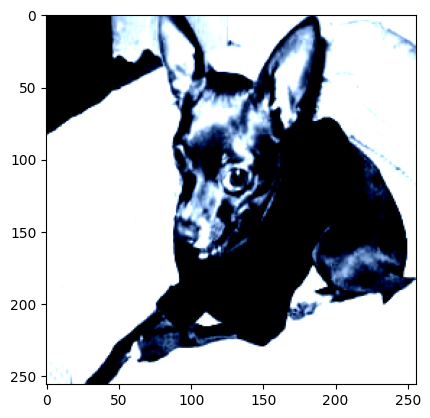

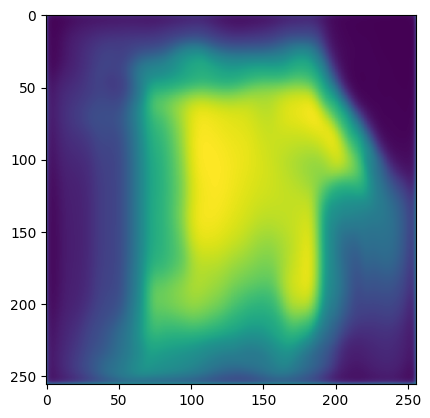

In [13]:
import matplotlib.pyplot as plt

with torch.no_grad():
  lightning_model = LitModel.load_from_checkpoint(checkpoint_callback.best_model_path).eval().cpu()

  image, mask = data_module.test_dataset[137]

  output = lightning_model(image.unsqueeze(0))
  output = torch.softmax(output, dim=1)
  output = output.squeeze()[1]
  #output = output.argmax(dim=1)

  plt.imshow(image.permute(1, 2, 0))
  plt.figure()
  plt.imshow(output.squeeze(0))

In [14]:
import torch
import numpy as np
import albumentations as A

from torch.utils.data import Dataset

from pathlib import Path
from PIL import Image


class DogsDataset_bin(Dataset):
    def __init__(self, images_paths: list[Path], transforms: A.Compose):
        self._images_paths = images_paths
        self._transforms = transforms

    def __len__(self):
        return len(self._images_paths)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        image_path = self._images_paths[index]
        image = np.asarray(Image.open(image_path).convert('RGB'))

        mask_path = image_path.parent.parent / 'labels' / image_path.name
        mask = np.asarray(Image.open(mask_path))

        transformed = self._transforms(image=image, mask=mask)

        return transformed['image'], transformed['mask'].type(torch.float32).unsqueeze(0)

In [15]:
import cv2
import os
import shutil
from urllib.request import urlopen
from pathlib import Path

import lightning.pytorch as pl
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
import albumentations.pytorch.transforms


class DogsDataModule_bin(pl.LightningDataModule):
    def __init__(self):
        super().__init__()

        self.augmentations = A.Compose([
            A.Resize(width=256, height=256),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.5),
            # A.Downscale(scale_range=(0.5, 0.75), interpolation_pair={'downscale': cv2.INTER_NEAREST, 'upscale': cv2.INTER_LINEAR},p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.pytorch.transforms.ToTensorV2(),
        ])
        self.transforms = A.Compose([
            A.Resize(width=256, height=256),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.pytorch.transforms.ToTensorV2(),
        ])

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def setup(self, stage):
        dataset_path = Path('oxford_pets_dogs_only_binarized_split')
        train_paths = sorted((dataset_path / 'train' / 'images').glob('*.png'))
        test_paths = sorted((dataset_path / 'test' / 'images').glob('*.png'))

        train_paths, val_paths = train_test_split(train_paths, test_size=0.2,
                                                  random_state=42)

        self.train_dataset = DogsDataset_bin(train_paths, self.augmentations)
        self.val_dataset = DogsDataset_bin(val_paths, self.transforms)
        self.test_dataset = DogsDataset_bin(test_paths, self.transforms)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=32, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=32)

In [16]:
from torch import nn

class SegmentationModel_bin(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # Conv2d-1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1) # Conv2d-3
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # MaxPool2d-5

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Conv2d-6
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  # Conv2d-8
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # MaxPool2d-10

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Conv2d-11
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)  # Conv2d-13
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)  # MaxPool2d-15

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # Conv2d-16
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # Conv2d-18
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)  # MaxPool2d-20

        self.conv9 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # Conv2d-21
        self.conv10 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # Conv2d-23

        # Decoder
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')  # UpsamplingNearest2d-25
        self.conv11 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)  # Conv2d-26
        self.conv12 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)  # Conv2d-28

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')  # UpsamplingNearest2d-30
        self.conv13 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)  # Conv2d-31
        self.conv14 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  # Conv2d-33

        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')  # UpsamplingNearest2d-35
        self.conv15 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)  # Conv2d-36
        self.conv16 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # Conv2d-38

        self.upsample4 = nn.Upsample(scale_factor=2, mode='nearest')  # UpsamplingNearest2d-40
        self.conv17 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # Conv2d-41
        self.conv18 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)  # Conv2d-43

    def forward(self, x):
        # Encoder
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool1(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.maxpool2(x)

        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.maxpool3(x)

        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.maxpool4(x)

        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))

        # Decoder
        x = self.upsample1(x)
        x = self.relu(self.conv11(x))
        x = self.relu(self.conv12(x))

        x = self.upsample2(x)
        x = self.relu(self.conv13(x))
        x = self.relu(self.conv14(x))

        x = self.upsample3(x)
        x = self.relu(self.conv15(x))
        x = self.relu(self.conv16(x))

        x = self.upsample4(x)
        x = self.relu(self.conv17(x))
        x = self.conv18(x)

        return x


In [17]:
import lightning.pytorch as pl
import torchmetrics


class LitModel_bin(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.network = SegmentationModel_bin()
        self.loss_function = nn.BCEWithLogitsLoss()
        self.accuracy = torchmetrics.Accuracy(task='binary')

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)

        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy)

    def configure_optimizers(self):
        # Tym razem użyjmy optimizera Adam - uczenie powinno być szybsze
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
data_module_bin = DogsDataModule_bin()
lightning_model_bin = LitModel_bin()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_acc', mode='max', verbose=True)
trainer = pl.Trainer(accelerator='gpu',
                     callbacks=[checkpoint_callback],
                     max_epochs=10)
trainer.fit(lightning_model_bin, datamodule=data_module_bin)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | network       | SegmentationModel_bin | 2.9 M  | train
1 | loss_function | BCEWithLogitsLoss     | 0      | train
2 | accuracy      | BinaryAccuracy        | 0      | train
----------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.772    Total estimated model para

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 102: 'val_acc' reached 0.59601 (best 0.59601), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=0-step=102.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 102: 'val_acc' reached 0.59601 (best 0.59601), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=0-step=102.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 204: 'val_acc' reached 0.71192 (best 0.71192), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=1-step=204.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 204: 'val_acc' reached 0.71192 (best 0.71192), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=1-step=204.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 306: 'val_acc' reached 0.78437 (best 0.78437), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=2-step=306.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 306: 'val_acc' reached 0.78437 (best 0.78437), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=2-step=306.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 408: 'val_acc' reached 0.82281 (best 0.82281), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=3-step=408.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 408: 'val_acc' reached 0.82281 (best 0.82281), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=3-step=408.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 510: 'val_acc' reached 0.84578 (best 0.84578), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=4-step=510.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 510: 'val_acc' reached 0.84578 (best 0.84578), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=4-step=510.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 612: 'val_acc' reached 0.85729 (best 0.85729), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=5-step=612.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 612: 'val_acc' reached 0.85729 (best 0.85729), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=5-step=612.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 714: 'val_acc' reached 0.86419 (best 0.86419), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=6-step=714.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 714: 'val_acc' reached 0.86419 (best 0.86419), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=6-step=714.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 816: 'val_acc' reached 0.87687 (best 0.87687), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=7-step=816.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 816: 'val_acc' reached 0.87687 (best 0.87687), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=7-step=816.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 918: 'val_acc' reached 0.88094 (best 0.88094), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=8-step=918.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 918: 'val_acc' reached 0.88094 (best 0.88094), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=8-step=918.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 1020: 'val_acc' reached 0.88676 (best 0.88676), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=9-step=1020.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 1020: 'val_acc' reached 0.88676 (best 0.88676), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=9-step=1020.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


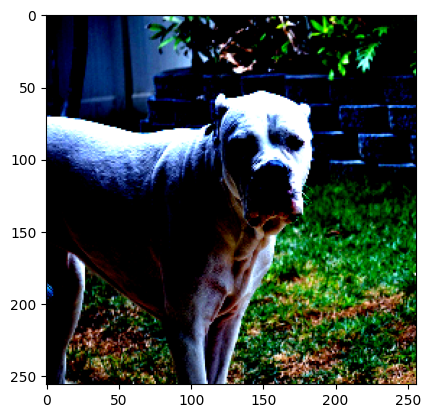

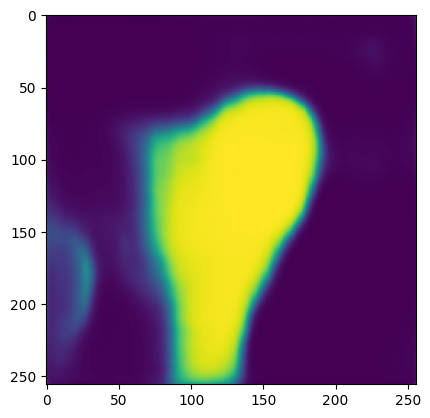

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    lightning_model_bin = LitModel_bin.load_from_checkpoint(checkpoint_callback.best_model_path).eval().cpu()

    image, mask = data_module.test_dataset[1]

    output = lightning_model_bin(image.unsqueeze(0))
    output = torch.sigmoid(output)
    output = output.squeeze()

    plt.imshow(image.permute(1, 2, 0))
    plt.figure()
    plt.imshow(output.squeeze(0))

### Bardziej złożone architektury i transfer learning.

Nasze eksperymenty z poprzednich zajęć, pokazały, że wykorzystanie warstw z wcześniej wytrenowanych (przykładowo na ImageNet) modeli, często pomaga z uzyskaniem lepszych wyników (także szybciej). Technika ta działa również w przypadku segmentacji – część naszej sieci, enkoder, służy przecież docelowo właśnie jako ekstraktor cech – więc zastosowanie tu gotowego, dobrze wyuczonego na dużym zbiorze danych ekstraktora, zdecydowanie ma sens.

Taka podmiana warstw w bardziej skomplikowanych architekturach (innych niż standardowy enkoder-dekoder) nie jest aż tak prosta – natomiast jak to często bywa, można sobie zadanie ułatwić przy pomocy odpowiednich bibliotek.

My skorzystamy teraz biblioteki z [segmentation-models-pytorch](https://smp.readthedocs.io/en/latest/) – która udostępnia gotowe elementy, takie jak gotowe implementacje najpopularniejszych funkcji kosztu/metryk i architektur (również z przetrenowanymi enkoderam) stosowanych przy segmentacji.

In [18]:
# segmentation_models nie jest domyślnie zainstalowane w Colabie – zmieńmy to!
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=43e03bd095d303b07ab706f57d6952aadbdea63b0d934b9d32493b66ad2d3d01
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=5c8c6eefffee57979491f0f2b89b8314c9b90a35997cf019fda665b4e53a1a1c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

<b>TODO4YOU</b>

Wykorzystaj `segmentation-models-pytorch`, żeby skorzystać z architektury U-net do segmentacji. Niech "backendem" modelu będzie resnet34, natomiast ustawienia funkcji kosztu, optimizera, liczby epok, pozostaw takie, jak przy naszym pierwszym modelu, nie używaj natomiast opcji "pretrenowanych" wag – tak, żeby porównać różnice wyników bezpośrednio między dwiema zastosowanymi architekturami.

Zwróć uwagę na dostępne gotowe metryki – często w zależności od zadania, interesują nas różne aspekty działania modelu (przykładowo recall/precision tradeoff) i wykorzystuje się więcej metryk poza samym accuracy – dodaj do monitorowanych podczas treningu metryk iou_score.

Pod koniec treningu wygeneruj i przeanalizuj wykres funkcji kosztu/monitorowanych metryk. Jak wartości IoU mają się do osiąganego accuracy?

In [19]:
import lightning.pytorch as pl
import torchmetrics

import segmentation_models_pytorch as smp


class LitModel_smp(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.network = smp.Unet(encoder_name='tu-resnet10t', classes=1)
        self.loss_function = nn.BCEWithLogitsLoss()

        metrics = torchmetrics.MetricCollection(
            torchmetrics.Accuracy(task='binary'),
            torchmetrics.Precision(task='binary'),
            torchmetrics.Recall(task='binary'),
            torchmetrics.F1Score(task='binary'),
        )
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.train_metrics.update(outputs, labels)

        self.log('train_loss', loss, prog_bar=True)
        self.log_dict(self.train_metrics)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.val_metrics.update(outputs, labels)

        self.log('val_loss', loss, prog_bar=True)
        self.log_dict(self.val_metrics, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.test_metrics.update(outputs, labels)

        self.log('test_loss', loss)
        self.log_dict(self.test_metrics)

    def configure_optimizers(self):
        # Tym razem użyjmy optimizera Adam - uczenie powinno być szybsze
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
data_module_bin = DogsDataModule_bin()
lightning_model_bin = LitModel_smp()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_BinaryF1Score', mode='max', verbose=True)
trainer = pl.Trainer(accelerator='gpu',
                     callbacks=[checkpoint_callback],
                     max_epochs=10)
trainer.fit(lightning_model_bin, datamodule=data_module_bin)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | network       | Unet              | 8.1 M  | train
1 | loss_function | BCEWithLogitsLoss | 0      | train
2 | train_metrics | MetricCollection  | 0      | train
3 | val_metrics   | MetricCollection  | 0      | train
4 | test_metrics  | MetricCollection  | 0      | train
------------------------------------------------------------
8.1 M     Trainable params
0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 102: 'val_BinaryF1Score' reached 0.93020 (best 0.93020), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=0-step=102.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 102: 'val_BinaryF1Score' reached 0.93020 (best 0.93020), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=0-step=102.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 204: 'val_BinaryF1Score' reached 0.93167 (best 0.93167), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=1-step=204.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 204: 'val_BinaryF1Score' reached 0.93167 (best 0.93167), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=1-step=204.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 306: 'val_BinaryF1Score' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 306: 'val_BinaryF1Score' was not in top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 408: 'val_BinaryF1Score' reached 0.93537 (best 0.93537), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=3-step=408.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 408: 'val_BinaryF1Score' reached 0.93537 (best 0.93537), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=3-step=408.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 510: 'val_BinaryF1Score' reached 0.94178 (best 0.94178), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=4-step=510.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 510: 'val_BinaryF1Score' reached 0.94178 (best 0.94178), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=4-step=510.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 612: 'val_BinaryF1Score' reached 0.94386 (best 0.94386), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=5-step=612.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 612: 'val_BinaryF1Score' reached 0.94386 (best 0.94386), saving model to '/content/lightning_logs/version_3/checkpoints/epoch=5-step=612.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 714: 'val_BinaryF1Score' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 714: 'val_BinaryF1Score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 816: 'val_BinaryF1Score' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 816: 'val_BinaryF1Score' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 918: 'val_BinaryF1Score' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 918: 'val_BinaryF1Score' was not in top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 1020: 'val_BinaryF1Score' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 1020: 'val_BinaryF1Score' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


<b>TODO4YOU</b>

Przeprowadź ten sam trening co poprzednio – ale tym razem używając pretrenowanych wag. Po skończeniu treningu, wygeneruj (jak zawsze) wykres przebiegu metryk/funkcji kosztu. Porównaj dane ze wszystkich trzech przeprowadzonych treningów i opdowiedz na pytania:
* Który z modeli "zbiegł się", osiągnął swoje "maksymalne" wyniki na zbiorze testowym najszybciej? Jak ma się do tego ewentualny transfer learning?
* Czy w którymś z modeli doszło do przeuczenia? Co mogło mieć na to wpływ (np. liczba parametrów)? Jak można to zredukować?
* Który z modeli osiągnął finalnie najlepsze wyniki? Czy była tu jakaś niespodzianka? Jakie czynniki mogły być być sekretem sukcesu naszego championa?

<b>TODO4YOU</b>

W ferworze testów zapomnieliśmy o najważniejszym – czas więc przejść do finału i wypuścić psy. Te z test setu.

Załadujmy z niego paręnaście zdjęć, i przejrzyjmy, wyświetlając obok/pod sobą oryginalne zdjęcia, i zdjęcia po wyzerowaniu części obrazu nie znajdującej się w przewidzianej masce segmentacji.

(chodzą plotki, że ten z grupy kto znajdzie najśmieszniej wysegmentowanego psa, jest zwolniony z pisania pracy magisterskiej – natomiast wciąż brak jest oficjalnego potwierdzenia)

## Zadanie jeszcze-bardziej-domowe

Na zajęciach skorzystaliśmy z "gotowca", w postaci implementacji U-Netu z zewnętrznej biblioteki. Natomiast nie zawsze implementacja architektury z której chemy skorzystać jest w jakimś źródle dostępna – warto jest w razie konieczności "złożyć" też bardziej skomplikowane sieci samemu.

W ramach rozwijania tej gałęzi drzewka umiejętności – zaimplementuj U-Net od zera, korzystając z jego schematu przedstawionego poniżej (pochodzi on z oryginalnego artykułu). Rozdzielczość danych wejściowych/wyjściowych trzeba będzie dostosować do naszego problemu.

<b>Uwaga:</b> Zainteresowani mogą pokusić się o zaznajomienie się z całością artykułu – jest on dostępny pod adresem: https://arxiv.org/pdf/1505.04597.pdf.

Podobnie sprawa ma się z metrykami/funkcjami kosztu – różne artykuły często wprowadzają różne ich wariacje, i gdy chcemy z nich skorzystać, jesteśmy skazani na samodzielne ich zaimplementowanie.

Korzystając z dokumentacji znajdź informacje, jak w PyTorch należy implementować własne funkcje kosztu/metryki – i korzystając z wzorów z wykładu/Internetu, samodzielnie zaimplementuj metrykę Dice Score/funkcje kosztu Dice Score Loss.

Będąc uzbrojonym w oba te elementy – przeprowadź przy ich użyciu trening – jakie wyniki udaje się uzyskać?





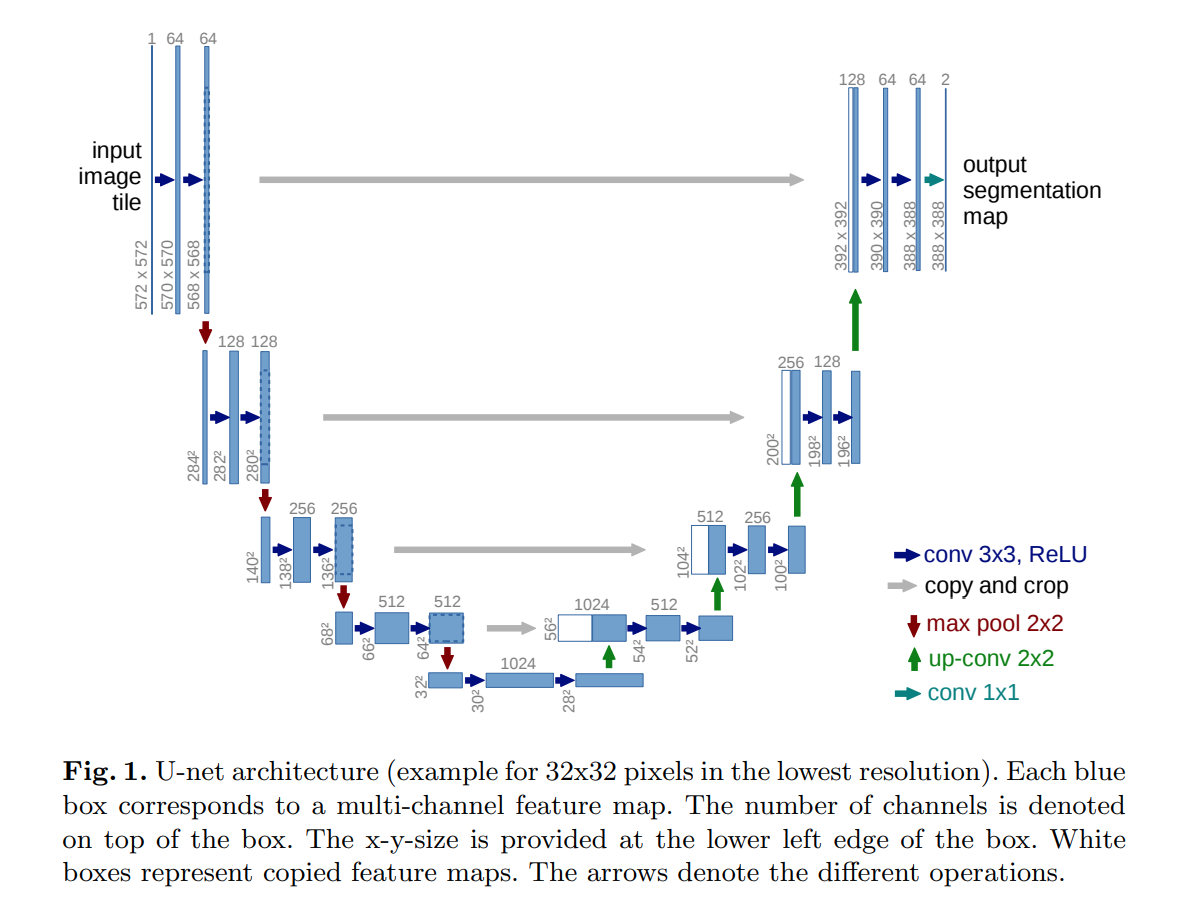

In [36]:
from torch import nn


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)

        self.max_pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)

        self.max_pool2 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)

        self.max_pool3 = nn.MaxPool2d(2)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)

        self.max_pool4 = nn.MaxPool2d(2)
        self.conv9 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv10 = nn.Conv2d(1024, 1024, 3, padding=1)

        self.up_conv1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv11 = nn.Conv2d(1024, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)

        self.up_conv2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv13 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv14 = nn.Conv2d(256, 256, 3, padding=1)

        self.up_conv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv15 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv16 = nn.Conv2d(128, 128, 3, padding=1)

        self.up_conv4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv17 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv18 = nn.Conv2d(64, 64, 3, padding=1)

        self.conv19 = nn.Conv2d(64, 2, 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        skip_1 = x

        x = self.max_pool1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)

        skip_2 = x

        x = self.max_pool2(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)

        skip_3 = x

        x = self.max_pool3(x)
        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.relu(x)

        skip_4 = x

        x = self.max_pool4(x)
        x = self.conv9(x)
        x = self.relu(x)
        x = self.conv10(x)
        x = self.relu(x)

        x = self.up_conv1(x)
        x = torch.cat((skip_4, x), dim=1)
        x = self.conv11(x)
        x = self.relu(x)
        x = self.conv12(x)
        x = self.relu(x)

        x = self.up_conv2(x)
        x = torch.cat((skip_3, x), dim=1)
        x = self.conv13(x)
        x = self.relu(x)
        x = self.conv14(x)
        x = self.relu(x)

        x = self.up_conv3(x)
        x = torch.cat((skip_2, x), dim=1)
        x = self.conv15(x)
        x = self.relu(x)
        x = self.conv16(x)
        x = self.relu(x)

        x = self.up_conv4(x)
        x = torch.cat((skip_1, x), dim=1)
        x = self.conv17(x)
        x = self.relu(x)
        x = self.conv18(x)
        x = self.relu(x)

        x = self.conv19(x)
        return x

In [34]:
import lightning.pytorch as pl
import torchmetrics


class Light_UNetModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.network = UNet()
        self.loss_function = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass',
                                              num_classes=2)

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.loss_function(outputs, labels)

        self.accuracy.update(outputs, labels)

        self.log('test_loss', loss)
        self.log('test_acc', self.accuracy)

    def configure_optimizers(self):
        # Tym razem użyjmy optimizera Adam - uczenie powinno być szybsze
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [35]:
data_module = DogsDataModule()
lightning_unet_model = Light_UNetModel()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_acc', mode='max', verbose=True)
trainer = pl.Trainer(accelerator='gpu',
                     callbacks=[checkpoint_callback],
                     max_epochs=10)
trainer.fit(lightning_unet_model, datamodule=data_module)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | network       | UNet               | 31.0 M | train
1 | loss_function | CrossEntropyLoss   | 0      | train
2 | accuracy      | MulticlassAccuracy | 0      | train
-------------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.127   Total estimated model params size (MB)
31   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 102: 'val_acc' reached 0.60299 (best 0.60299), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=0-step=102.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 102: 'val_acc' reached 0.60299 (best 0.60299), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=0-step=102.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 204: 'val_acc' reached 0.66552 (best 0.66552), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=1-step=204.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 204: 'val_acc' reached 0.66552 (best 0.66552), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=1-step=204.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 306: 'val_acc' reached 0.67452 (best 0.67452), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=2-step=306.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 306: 'val_acc' reached 0.67452 (best 0.67452), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=2-step=306.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 408: 'val_acc' reached 0.78119 (best 0.78119), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=3-step=408.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 408: 'val_acc' reached 0.78119 (best 0.78119), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=3-step=408.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 510: 'val_acc' reached 0.82303 (best 0.82303), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=4-step=510.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 510: 'val_acc' reached 0.82303 (best 0.82303), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=4-step=510.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 612: 'val_acc' reached 0.84306 (best 0.84306), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=5-step=612.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 612: 'val_acc' reached 0.84306 (best 0.84306), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=5-step=612.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 714: 'val_acc' reached 0.86010 (best 0.86010), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=6-step=714.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 714: 'val_acc' reached 0.86010 (best 0.86010), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=6-step=714.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 816: 'val_acc' reached 0.87069 (best 0.87069), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=7-step=816.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 816: 'val_acc' reached 0.87069 (best 0.87069), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=7-step=816.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 918: 'val_acc' reached 0.88013 (best 0.88013), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=8-step=918.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 918: 'val_acc' reached 0.88013 (best 0.88013), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=8-step=918.ckpt' as top 1
/usr/local/lib/python3.10/dist-packages/albumentations/pytorch/transforms.py:54: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(mask)


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 1020: 'val_acc' reached 0.88701 (best 0.88701), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=9-step=1020.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 1020: 'val_acc' reached 0.88701 (best 0.88701), saving model to '/content/lightning_logs/version_2/checkpoints/epoch=9-step=1020.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


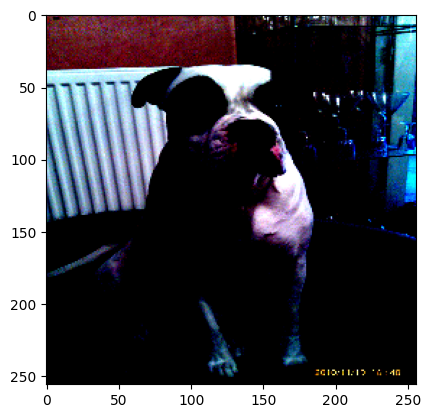

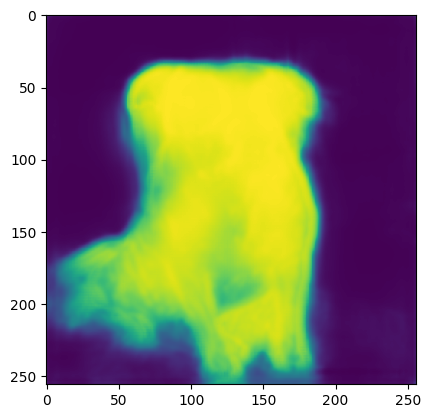

In [38]:
import matplotlib.pyplot as plt

with torch.no_grad():
  lightning_u_model = Light_UNetModel.load_from_checkpoint(checkpoint_callback.best_model_path).eval().cpu()

  image, mask = data_module.test_dataset[0]

  output = lightning_u_model(image.unsqueeze(0))
  output = torch.softmax(output, dim=1)
  output = output.squeeze()[1]
  #output = output.argmax(dim=1)

  plt.imshow(image.permute(1, 2, 0))
  plt.figure()
  plt.imshow(output.squeeze(0))

In [40]:
class BinaryDiceLoss(nn.Module):
    def __init__(self):
        self.smooth = 1e-5

    def forward(self, preds, target):
        preds = torch.sigmoid(preds)
        intersection = (preds * target).sum()
        return 1. - (2. * intersection + self.smooth) / (preds.sum() + target.sum() + self.smooth)